# Семинар №3

### Чтение картинки

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import cv2
import sklearn
import PIL
import torch
import torchvision
from matplotlib import cm

import warnings
warnings.filterwarnings('ignore')

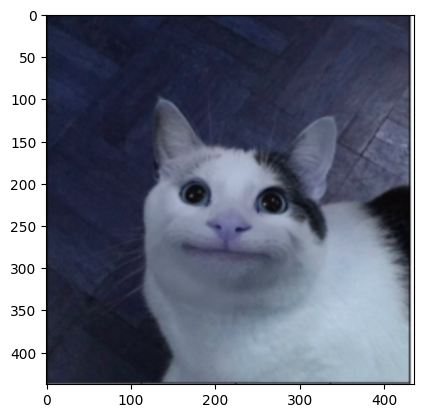

In [2]:
image = cv2.imread('./image.png')
plt.imshow(image);

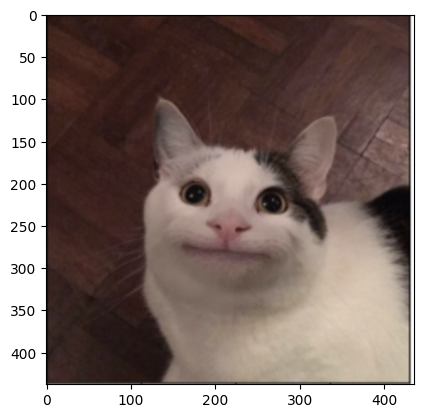

In [3]:
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb);

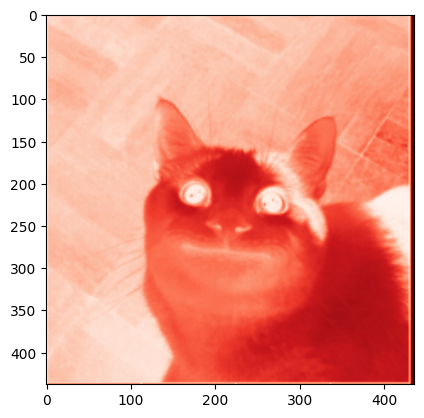

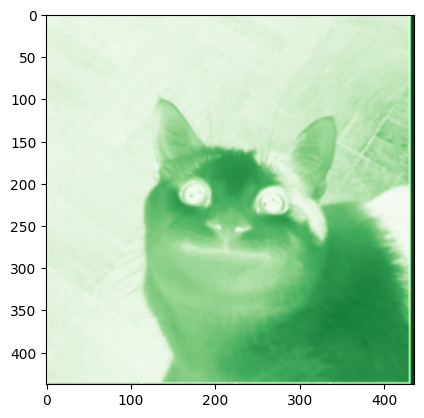

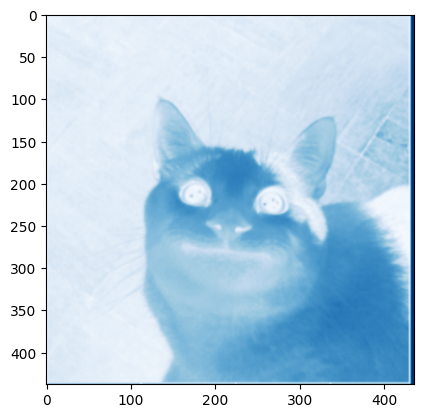

In [4]:
img_mat = np.array(image_rgb)
plt.imshow(img_mat[:, :, 0], cmap=cm.Reds)
plt.show()

img_mat = np.array(image_rgb)
plt.imshow(img_mat[:, :, 1], cmap=cm.Greens)
plt.show()

img_mat = np.array(image_rgb)
plt.imshow(img_mat[:, :, 2], cmap=cm.Blues)
plt.show()

### Операция свертки

- Количество входных каналов `in_channels`
- Количество выходных каналов `out_channels`
- Размер ядра `kernel_size`
- Шаг `stride`
- Паддинг `padding`
- Режим паддинга `padding_mode` (`'zeros'`, `'reflect'`, ...)

In [5]:
bw_image = cv2.imread('./image.png', cv2.IMREAD_GRAYSCALE)

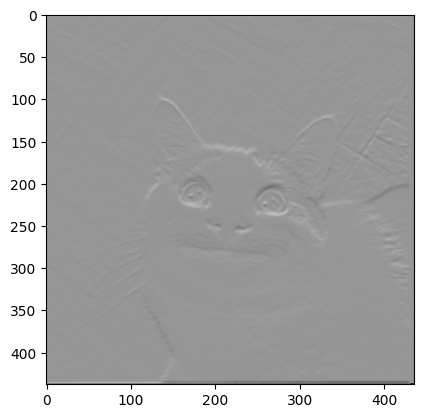

In [6]:
from scipy.signal import convolve2d

G_y = np.array([
    [1, 2, 1],
    [0, 0, 0],
    [-1, -2, -1]
])

res_y = convolve2d(bw_image, G_y, "same")
plt.imshow(res_y, cmap=plt.cm.Greys_r)

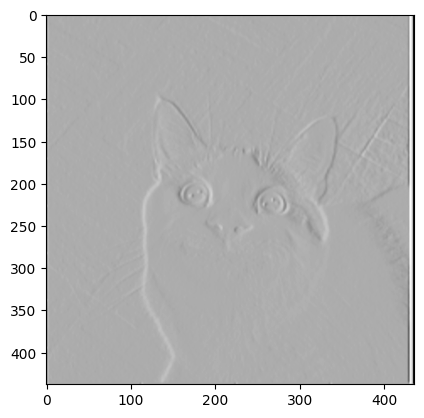

In [7]:
G_x = np.array([
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]
])

res_x = convolve2d(bw_image, G_y.T, "same")
plt.imshow(res_x, cmap=plt.cm.Greys_r)

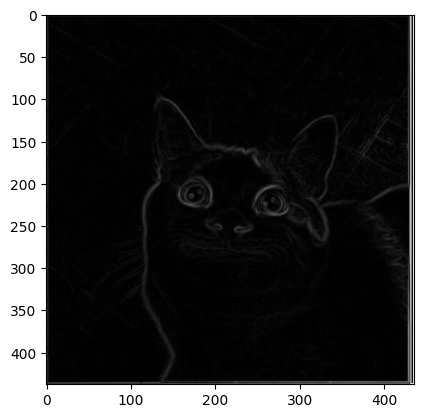

In [8]:
res_sobel = (res_x**2 + res_y**2)**0.5
plt.imshow(res_sobel, cmap=plt.cm.Greys_r)

### Свертка

In [9]:
conv2d = torch.nn.Conv2d(in_channels=3, out_channels=5, kernel_size=3)

In [10]:
image_rgb.shape

(438, 436, 3)

In [11]:
torch.tensor([
    [1, 2],
    [3, 4]
]).t()

tensor([[1, 3],
        [2, 4]])

In [12]:
image_rgb.transpose((0, -1, 1)).shape

(438, 3, 436)

In [13]:
image_torch = torch.tensor(image_rgb.transpose((-1, 0, 1)))

In [14]:
image_torch.unsqueeze(0).shape

torch.Size([1, 3, 438, 436])

In [15]:
conv2d(image_torch.unsqueeze(0).float()).shape

torch.Size([1, 5, 436, 434])

In [16]:
conv2d

Conv2d(3, 5, kernel_size=(3, 3), stride=(1, 1))

### Свёрточная нейронная сеть для бинарной классификации

In [17]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from tqdm import tqdm
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm


import warnings
warnings.filterwarnings('ignore')

In [21]:
train_dir = "./data/training_set/training_set/"
val_dir = "./data/test_set/test_set/"

In [22]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

valid_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
valid_data = datasets.ImageFolder(val_dir, transform=valid_transforms)

In [23]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')

Number of training examples: 8005
Number of validation examples: 2023


In [24]:
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(valid_data, batch_size=128, shuffle=True)

In [25]:
train_data[0]

(tensor([[[0.1529, 0.1569, 0.1608,  ..., 0.8118, 0.8000, 0.7843],
          [0.1569, 0.1569, 0.1608,  ..., 0.7922, 0.7843, 0.7765],
          [0.1529, 0.1529, 0.1490,  ..., 0.7686, 0.7804, 0.7922],
          ...,
          [0.1137, 0.1059, 0.0902,  ..., 0.1686, 0.1529, 0.1922],
          [0.1216, 0.1098, 0.0902,  ..., 0.1529, 0.1608, 0.2039],
          [0.1216, 0.1059, 0.0863,  ..., 0.2078, 0.1804, 0.1725]],
 
         [[0.1725, 0.1725, 0.1765,  ..., 0.8000, 0.7882, 0.7725],
          [0.1765, 0.1725, 0.1765,  ..., 0.7765, 0.7725, 0.7647],
          [0.1725, 0.1686, 0.1647,  ..., 0.7529, 0.7608, 0.7725],
          ...,
          [0.1059, 0.0980, 0.0824,  ..., 0.1137, 0.1059, 0.1490],
          [0.1137, 0.1020, 0.0824,  ..., 0.1020, 0.1137, 0.1647],
          [0.1137, 0.0980, 0.0784,  ..., 0.1569, 0.1333, 0.1333]],
 
         [[0.1569, 0.1647, 0.1725,  ..., 0.6941, 0.6627, 0.6392],
          [0.1608, 0.1647, 0.1725,  ..., 0.6745, 0.6510, 0.6314],
          [0.1569, 0.1608, 0.1647,  ...,

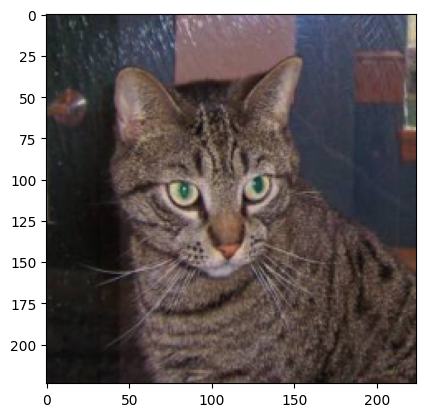

In [26]:
plt.imshow(train_data[0][0].permute(1, 2, 0))

In [27]:
model = models.resnet18(pretrained=True)

In [28]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [29]:
model.fc = nn.Linear(model.fc.in_features, 2)

In [30]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [31]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [32]:
def train(model, optimizer, n_epochs=10, device='mps'):
    
    model = model.to(device)
    accuracies, losses = [], []
    for epoch in range(n_epochs):
        
        # обучение
        for x_train, y_train in tqdm(train_dataloader):
            x_train = x_train.to(device)
            y_train = y_train.to(device)
            y_pred = model(x_train)
            loss = F.cross_entropy(y_pred, y_train)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        # валидация
        val_loss = []
        val_accuracy = []
        with torch.no_grad():
            for x_val, y_val in tqdm(val_dataloader):
                x_val = x_val.to(device)
                y_val = y_val.to(device)
                y_pred = model(x_val).to(device)
                loss = F.cross_entropy(y_pred, y_val)
                val_loss.append(loss.cpu().numpy())
                val_accuracy.extend((torch.argmax(y_pred, dim=-1) == y_val).cpu().numpy().tolist())

        accuracies.append(np.mean(val_accuracy))
        losses.append(np.mean(val_loss))
        print(f'Epoch: {epoch}, loss: {np.mean(val_loss)}, accuracy: {np.mean(val_accuracy)}')
    return accuracies, losses

In [33]:
accs, losses = train(model, optimizer)

100%|██████████| 16/16 [00:08<00:00,  1.92it/s]


Epoch: 0, loss: 0.08558179438114166, accuracy: 0.972318339100346


100%|██████████| 16/16 [00:08<00:00,  1.92it/s]


Epoch: 1, loss: 0.06006750836968422, accuracy: 0.9792387543252595


100%|██████████| 16/16 [00:08<00:00,  1.90it/s]


Epoch: 2, loss: 0.053269945085048676, accuracy: 0.9777558082056352


100%|██████████| 16/16 [00:08<00:00,  1.93it/s]


Epoch: 3, loss: 0.04941878840327263, accuracy: 0.9826989619377162


100%|██████████| 16/16 [00:08<00:00,  1.90it/s]


Epoch: 4, loss: 0.04704616218805313, accuracy: 0.9851705388037568


100%|██████████| 16/16 [00:10<00:00,  1.55it/s]


Epoch: 5, loss: 0.04784020781517029, accuracy: 0.9836875926841325


100%|██████████| 16/16 [00:08<00:00,  1.83it/s]


Epoch: 6, loss: 0.04072972387075424, accuracy: 0.9871478002965892


100%|██████████| 16/16 [00:08<00:00,  1.91it/s]


Epoch: 7, loss: 0.04256444796919823, accuracy: 0.9866534849233811


100%|██████████| 16/16 [00:08<00:00,  1.88it/s]


Epoch: 8, loss: 0.03897424787282944, accuracy: 0.9856648541769649


100%|██████████| 16/16 [00:08<00:00,  1.89it/s]

Epoch: 9, loss: 0.0448627769947052, accuracy: 0.9856648541769649


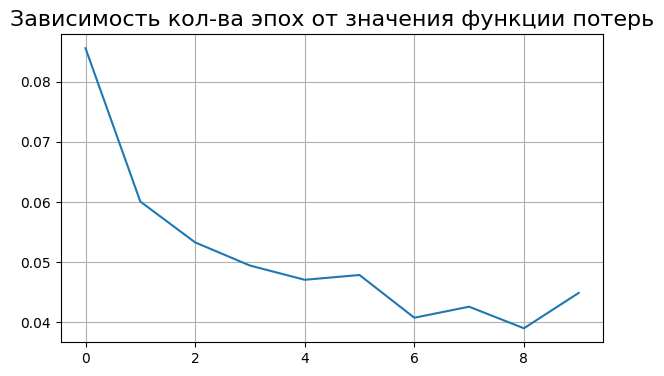

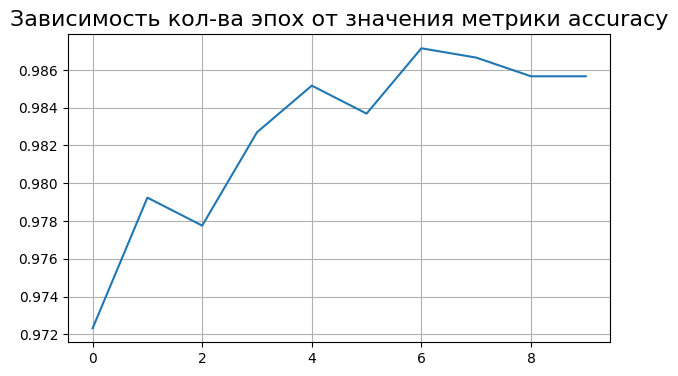

In [34]:
def plot_metrics(metric, caption):
    plt.figure(figsize=(7,4))
    plt.plot(list(range(0, 10)), metric)
    plt.title(f'Зависимость кол-ва эпох от значения {caption}', fontsize=16)
    plt.grid()
    

plot_metrics(losses, 'функции потерь')
plot_metrics(accs, 'метрики accuracy')

### Домашнее задание

- Обучите нейронную сеть на датасете indoor-outdoor и оцените её качество (3 балла)
- Для обучения введите автоматическое разбиение на train/val в пропорции 70/30 (0.5 балла)
- Постройте графики метрик качества (1 балл)
- Попробуйте поменять гиперпараметры и сделать выводы о том, как это влияет на качество (0.5 балла). 

### По желанию (*но всячески приветствуется*)
- Попробуйте вычислить F1-меру и построить confusion matrix
- При разбиение на train/val сравните результаты со стратификацией и без нее

*Цель:* выработать навык обучения нейронных сетей (в частности сверточных) на основе средств PyTorch, начиная от загрузки датасетами и заканчивая выводами результатов, их логгированием, сравнением и анализом.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
import os

# 数据增强和标准化
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),  # 调整图像大小
        transforms.RandomHorizontalFlip(),  # 随机水平翻转
        transforms.ToTensor(),  # 转为Tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 标准化
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
}

# 目录路径
data_dir = 'train'  # 确保目录结构正确，train/dcp、train/GT 和 train/hazy 目录存在

# 加载数据集
# 将所有数据加载到 ImageFolder 中
full_dataset = ImageFolder(root=data_dir, transform=data_transforms['train'])

# 划分数据集，80%训练，20%验证
train_size = int(0.7 * len(full_dataset))  # 80% 用于训练
val_size = len(full_dataset) - train_size  # 剩下的 20% 用于验证

train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# 创建数据加载器
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True, num_workers=4)

# 加载预训练的ResNet18模型
model = models.resnet18(pretrained=True)

# 修改最后一层，输出三个类别
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 3)  # 3个类别

# 使用GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# 损失函数
criterion = nn.CrossEntropyLoss()

# 优化器
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 训练模型的函数
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    best_model_wts = model.state_dict()
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        
        # 每个epoch都有一个训练和验证阶段
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # 设置为训练模式
                data_loader = train_loader
            else:
                model.eval()   # 设置为验证模式
                data_loader = val_loader

            running_loss = 0.0
            running_corrects = 0

            # 遍历数据
            for inputs, labels in data_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # 前向传播
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # 反向传播 + 优化
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(data_loader.dataset)
            epoch_acc = running_corrects.double() / len(data_loader.dataset)

            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            # 复制模型
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

    print(f"Best val Acc: {best_acc:.4f}")

    # 加载最佳模型权重
    model.load_state_dict(best_model_wts)
    return model

# 开始训练
model = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)

# 保存模型
torch.save(model.state_dict(), 'resnet18_best.pth')


E:\Anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
E:\Anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10
train Loss: 0.3628 Acc: 0.8658
val Loss: 0.5080 Acc: 0.8328
Epoch 2/10
train Loss: 0.2538 Acc: 0.9072
val Loss: 0.3746 Acc: 0.8653
Epoch 3/10
train Loss: 0.2106 Acc: 0.9245
val Loss: 0.1530 Acc: 0.9495
Epoch 4/10
train Loss: 0.1673 Acc: 0.9370
val Loss: 0.3604 Acc: 0.9214
Epoch 5/10
train Loss: 0.1699 Acc: 0.9375
val Loss: 0.1281 Acc: 0.9540
Epoch 6/10
train Loss: 0.1223 Acc: 0.9476
val Loss: 0.2142 Acc: 0.9214
Epoch 7/10
train Loss: 0.1311 Acc: 0.9490
val Loss: 0.2053 Acc: 0.9203
Epoch 8/10
train Loss: 0.1177 Acc: 0.9567
val Loss: 0.1158 Acc: 0.9607
Epoch 9/10
train Loss: 0.1313 Acc: 0.9538
val Loss: 0.1283 Acc: 0.9607
Epoch 10/10
train Loss: 0.1379 Acc: 0.9524
val Loss: 0.2256 Acc: 0.9315
Best val Acc: 0.9607


In [2]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torch import nn
import os
from tqdm import tqdm  # 用于显示进度条

# 数据预处理（与训练时一致）
data_transforms = {
    'test': transforms.Compose([
        transforms.Resize((224, 224)),  # 调整图像大小
        transforms.ToTensor(),  # 转为Tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 标准化
    ])
}

# 加载测试数据
test_dir = 'test'  # 测试数据目录，包含 dcp, GT, hazy 文件夹

# 创建测试数据集
test_dataset = datasets.ImageFolder(root=test_dir, transform=data_transforms['test'])

# 创建测试数据加载器
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

# 加载训练好的模型
model = models.resnet18(pretrained=False)  # 使用未经预训练的ResNet18
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 3)  # 3个类别

# 加载模型权重
model.load_state_dict(torch.load('resnet18_best.pth'))

# 使用 GPU 如果有
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# 设置为评估模式
model.eval()

# 进行推断
def evaluate_model(model, test_loader):
    all_preds = []
    all_labels = []
    with torch.no_grad():  # 不需要计算梯度
        for inputs, labels in tqdm(test_loader, desc="Evaluating", ncols=100):  # 进度条显示
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)  # 取最大概率的类别

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_preds, all_labels

# 获取模型预测结果和真实标签
predictions, ground_truths = evaluate_model(model, test_loader)

# 显示结果（例如打印预测的类别标签）
for idx, (pred, gt) in enumerate(zip(predictions, ground_truths)):
    print(f"Image {idx + 1} - Predicted: {test_dataset.classes[pred]}, Ground Truth: {test_dataset.classes[gt]}")

# 如果需要保存到文件，可以使用如下代码
import numpy as np

# 保存预测结果到文件
np.savetxt('predictions.txt', predictions, fmt='%d')


E:\Anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Evaluating: 100%|█████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/it]

Image 1 - Predicted: GT, Ground Truth: GT
Image 2 - Predicted: hazy, Ground Truth: GT
Image 3 - Predicted: dcp, Ground Truth: GT
Image 4 - Predicted: GT, Ground Truth: GT
Image 5 - Predicted: GT, Ground Truth: GT
Image 6 - Predicted: GT, Ground Truth: GT
Image 7 - Predicted: GT, Ground Truth: GT
Image 8 - Predicted: GT, Ground Truth: GT
Image 9 - Predicted: GT, Ground Truth: GT
Image 10 - Predicted: GT, Ground Truth: GT
Image 11 - Predicted: dcp, Ground Truth: dcp
Image 12 - Predicted: dcp, Ground Truth: dcp
Image 13 - Predicted: dcp, Ground Truth: dcp
Image 14 - Predicted: dcp, Ground Truth: dcp
Image 15 - Predicted: dcp, Ground Truth: dcp
Image 16 - Predicted: dcp, Ground Truth: dcp
Image 17 - Predicted: dcp, Ground Truth: dcp
Image 18 - Predicted: dcp, Ground Truth: dcp
Image 19 - Predicted: dcp, Ground Truth: dcp
Image 20 - Predicted: dcp, Ground Truth: dcp
Image 21 - Predicted: hazy, Ground Truth: hazy
Image 22 - Predicted: hazy, Ground Truth: hazy
Image 23 - Predicted: hazy, Grou